In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import calplot
import numpy as np
import seaborn as sns
from scipy.spatial.distance import euclidean
import scipy.stats as stats
import random
import folium
from folium.plugins import HeatMap, HeatMapWithTime
from folium.features import GeoJson, GeoJsonTooltip
import json
from shapely.geometry import shape

In [2]:
df=pd.read_csv('SF_crime_data.csv')

df.columns = df.columns.str.strip()

df['Incident Date'] = pd.to_datetime(df['Incident Date'], errors='coerce')


# Crime Trend Before and After Lockdown

In [3]:
start_date = '2018-03-01'
end_date = '2023-01-01'

filtered_df = df[(df['Incident Date'] >= start_date) & (df['Incident Date'] < end_date)]
sorted_df = filtered_df.sort_values(by='Incident Date')
sorted_df['Incident Date'] = pd.to_datetime(sorted_df['Incident Date'])
sorted_df = sorted_df.set_index('Incident Date')
incidents_per_month = sorted_df.resample('M').size().reset_index(name='Incident Count')

C:\Users\UPASANA\AppData\Local\Temp\ipykernel_47172\2412485726.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  incidents_per_month = sorted_df.resample('M').size().reset_index(name='Incident Count')


C:\Users\UPASANA\AppData\Local\Temp\ipykernel_47172\348590755.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  filtered_df.groupby([pd.Grouper(freq='M'), 'Incident Category'])


VEHICLE THEFT
VANDALISM
BURGLARY
DRUG/NARCOTIC
ASSAULT


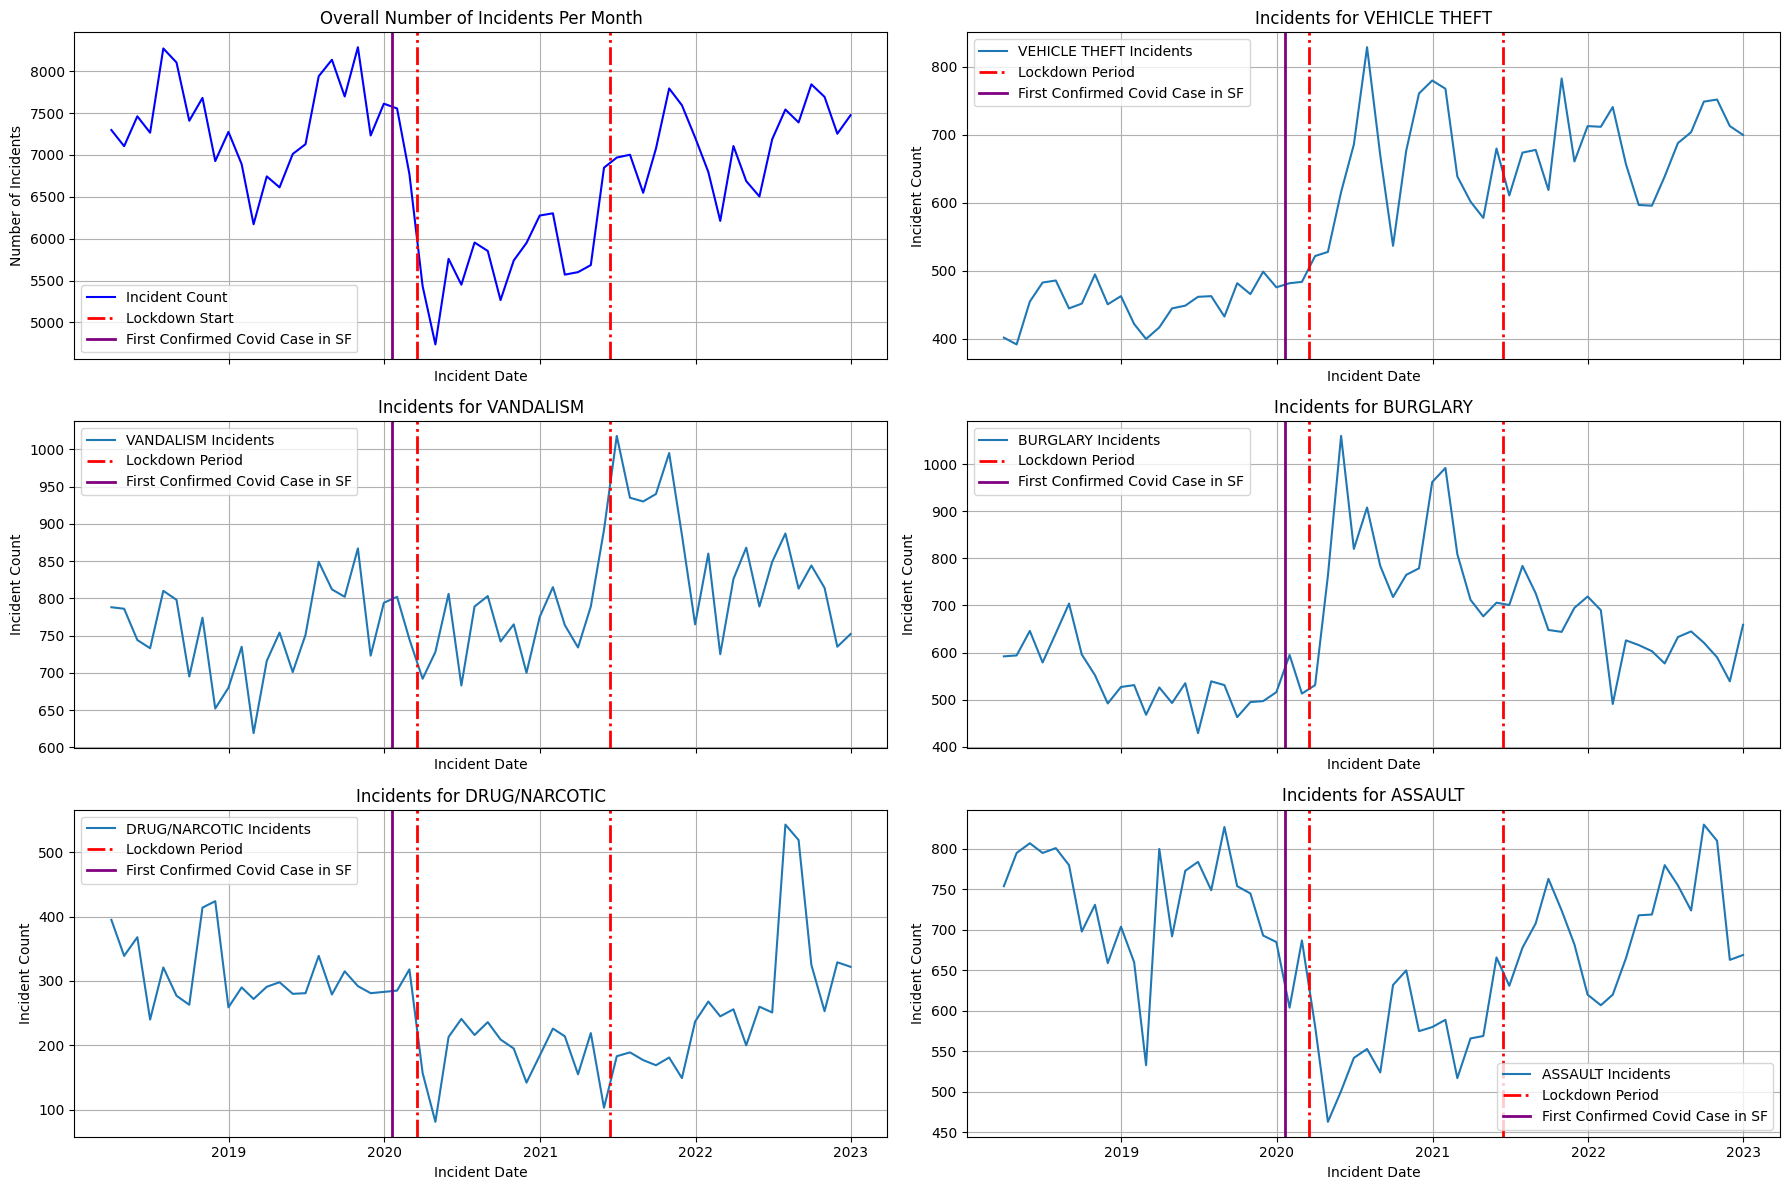

In [4]:
chosen_categories = ['VEHICLE THEFT', 'VANDALISM', 'BURGLARY', 'DRUG/NARCOTIC', 'ASSAULT']
filtered_df = sorted_df[sorted_df['Incident Category'].isin(chosen_categories)]

incidents_per_month_by_category = (
    filtered_df.groupby([pd.Grouper(freq='M'), 'Incident Category'])
    .size()
    .reset_index(name='Incident Count')
)

fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True)

axes = axes.flatten()
first_covid_date = pd.to_datetime('2020-01-20')


lockdown_liftoff = pd.to_datetime('2021-06-15')


highlight_date = pd.to_datetime('2020-03-17')




axes[0].plot(incidents_per_month['Incident Date'], incidents_per_month['Incident Count'], linestyle='-', label='Incident Count', color='b')
axes[0].axvline(x=highlight_date, color='red', linestyle='-.', linewidth=2, label="Lockdown Start")
axes[0].axvline(x=lockdown_liftoff, color='red', linestyle='-.', linewidth=2)
axes[0].axvline(x=first_covid_date, color='purple', linestyle='solid', linewidth=2, label="First Confirmed Covid Case in SF")
axes[0].set_title('Overall Number of Incidents Per Month')
axes[0].set_ylabel('Number of Incidents')
axes[0].set_xlabel('Incident Date')
axes[0].legend()
axes[0].grid(True)

for i, category in enumerate(chosen_categories):
    category_data = incidents_per_month_by_category[incidents_per_month_by_category['Incident Category'] == category]
    axes[i + 1].plot(category_data['Incident Date'], category_data['Incident Count'], linestyle='-', label=category + ' Incidents')
    axes[i + 1].axvline(x=highlight_date, color='red', linestyle='-.', linewidth=2, label='Lockdown Period')
    axes[i + 1].axvline(x=lockdown_liftoff, color='red', linestyle='-.', linewidth=2, )
    axes[i + 1].axvline(x=first_covid_date, color='purple', linestyle='solid', linewidth=2, label='First Confirmed Covid Case in SF')
    axes[i + 1].set_title(f'Incidents for {category}')
    axes[i + 1].set_ylabel('Incident Count')
    axes[i + 1].set_xlabel('Incident Date')
    axes[i + 1].legend()
    axes[i + 1].grid(True)
    print(category)


plt.tight_layout()
plt.show()


## During lockdown - 2020-03-17 to 2021-06-15

In [5]:
with open("sf_districts.geojson", "r") as f:
    geojson_data = json.load(f)
lockdown_start = pd.to_datetime('2020-03-17')
lockdown_end = pd.to_datetime('2021-06-15')
df_lockdown = df[(df['Incident Date'] >= lockdown_start) & (df['Incident Date'] <= lockdown_end)]

df_lockdown = df_lockdown.dropna(subset=['Incident Latitude', 'Incident Longitude'])

crime_counts = df_lockdown.groupby("Incident PdDistrict").size().reset_index(name="crime_count")
crime_counts['Incident PdDistrict'] = crime_counts['Incident PdDistrict'].str.strip().str.upper()

for feature in geojson_data["features"]:
    feature["properties"]["district"] = feature["properties"]["district"].strip().upper()

crime_dict = dict(zip(crime_counts["Incident PdDistrict"], crime_counts["crime_count"]))
for feature in geojson_data["features"]:
    district = feature["properties"]["district"]
    feature["properties"]["crime_count"] = crime_dict.get(district, 0)

m1 = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

folium.Choropleth(
    geo_data=geojson_data,
    name="choropleth",
    data=crime_counts,
    columns=["Incident PdDistrict", "crime_count"],
    key_on="feature.properties.district",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of Crimes per District (Lockdown)"
).add_to(m1)


folium.GeoJson(
    geojson_data,
    name="District Tooltips",
    tooltip=GeoJsonTooltip(
        fields=["district", "crime_count"],
        aliases=["District:", "Crimes:"],
        sticky=False
    )
).add_to(m1)

for feature in geojson_data["features"]:
    district_name = feature["properties"]["district"]
    polygon = shape(feature["geometry"])
    centroid = polygon.centroid
    folium.Marker(
        [centroid.y, centroid.x],
        icon=folium.DivIcon(
            html=f"""<div style="font-size: 10pt; font-weight: bold;">{district_name}</div>"""
        )
    ).add_to(m1)

folium.LayerControl().add_to(m1)
m1.save('map_lockdown.html')
m1

## Before lockdown - 2018-03-17 to 2020-03-16

In [6]:
lockdown_start = pd.to_datetime('2018-03-17')
lockdown_end = pd.to_datetime('2019-06-15')
df_lockdown = df[(df['Incident Date'] >= lockdown_start) & (df['Incident Date'] <= lockdown_end)]

df_lockdown = df_lockdown.dropna(subset=['Incident Latitude', 'Incident Longitude'])

crime_counts = df_lockdown.groupby("Incident PdDistrict").size().reset_index(name="crime_count")
crime_counts['Incident PdDistrict'] = crime_counts['Incident PdDistrict'].str.strip().str.upper()

for feature in geojson_data["features"]:
    feature["properties"]["district"] = feature["properties"]["district"].strip().upper()

crime_dict = dict(zip(crime_counts["Incident PdDistrict"], crime_counts["crime_count"]))
for feature in geojson_data["features"]:
    district = feature["properties"]["district"]
    feature["properties"]["crime_count"] = crime_dict.get(district, 0)

m2 = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

folium.Choropleth(
    geo_data=geojson_data,
    name="choropleth",
    data=crime_counts,
    columns=["Incident PdDistrict", "crime_count"],
    key_on="feature.properties.district",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of Crimes per District (Before lockdown)"
).add_to(m2)


folium.GeoJson(
    geojson_data,
    name="District Tooltips",
    tooltip=GeoJsonTooltip(
        fields=["district", "crime_count"],
        aliases=["District:", "Crimes:"],
        sticky=False
    )
).add_to(m2)

for feature in geojson_data["features"]:
    district_name = feature["properties"]["district"]
    polygon = shape(feature["geometry"])
    centroid = polygon.centroid
    folium.Marker(
        [centroid.y, centroid.x],
        icon=folium.DivIcon(
            html=f"""<div style="font-size: 10pt; font-weight: bold;">{district_name}</div>"""
        )
    ).add_to(m2)

folium.LayerControl().add_to(m2)
m2.save('map_lockdown.html')
m2

## After lockdown - 2022-03-17 to 2023-06-15

In [7]:
lockdown_start = pd.to_datetime('2022-03-17')
lockdown_end = pd.to_datetime('2023-06-15')

df_lockdown = df[(df['Incident Date'] >= lockdown_start) & (df['Incident Date'] <= lockdown_end)]

df_lockdown = df_lockdown.dropna(subset=['Incident Latitude', 'Incident Longitude'])

crime_counts = df_lockdown.groupby("Incident PdDistrict").size().reset_index(name="crime_count")
crime_counts['Incident PdDistrict'] = crime_counts['Incident PdDistrict'].str.strip().str.upper()

for feature in geojson_data["features"]:
    feature["properties"]["district"] = feature["properties"]["district"].strip().upper()

crime_dict = dict(zip(crime_counts["Incident PdDistrict"], crime_counts["crime_count"]))
for feature in geojson_data["features"]:
    district = feature["properties"]["district"]
    feature["properties"]["crime_count"] = crime_dict.get(district, 0)

m3 = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

folium.Choropleth(
    geo_data=geojson_data,
    name="choropleth",
    data=crime_counts,
    columns=["Incident PdDistrict", "crime_count"],
    key_on="feature.properties.district",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of Crimes per District (Before lockdown)"
).add_to(m3)


folium.GeoJson(
    geojson_data,
    name="District Tooltips",
    tooltip=GeoJsonTooltip(
        fields=["district", "crime_count"],
        aliases=["District:", "Crimes:"],
        sticky=False
    )
).add_to(m3)

for feature in geojson_data["features"]:
    district_name = feature["properties"]["district"]
    polygon = shape(feature["geometry"])
    centroid = polygon.centroid
    folium.Marker(
        [centroid.y, centroid.x],
        icon=folium.DivIcon(
            html=f"""<div style="font-size: 10pt; font-weight: bold;">{district_name}</div>"""
        )
    ).add_to(m3)

folium.LayerControl().add_to(m3)
m3.save('map_lockdown.html')
m3

## Bokeh Plot

In [25]:
import pandas as pd
import numpy as np
import os
from bokeh.plotting import figure, output_notebook, show, save, output_file
from bokeh.models import ColumnDataSource, Select, LinearColorMapper, ColorBar, HoverTool, CustomJS
from bokeh.models import BasicTickFormatter, PrintfTickFormatter  # Import proper formatters
from bokeh.layouts import column, row
from bokeh.palettes import YlOrRd9
from bokeh.transform import transform
from bokeh.resources import CDN
from bokeh.models.tickers import FixedTicker

# Enable notebook output
output_notebook()

# Create docs directory if it doesn't exist
docs_dir = "docs"
if not os.path.exists(docs_dir):
    os.makedirs(docs_dir)

# Load the data
print("Loading data...")
df = pd.read_csv("SF_crime_data.csv")


# Clean and prepare the data
df["Incident Date"] = pd.to_datetime(df["Incident Date"], errors='coerce')

start_date = pd.to_datetime("2018-03-17")
end_date = pd.to_datetime("2023-06-15")
df = df[(df["Incident Date"] >= start_date) & (df["Incident Date"] <= end_date)]

df["Incident TimeOfDay"] = pd.to_numeric(df["Incident TimeOfDay"], errors='coerce')
df = df.dropna(subset=["Incident Category", "Incident TimeOfDay", "Incident PdDistrict"])

# Define pandemic periods
df['Period'] = np.where(
    (df["Incident Date"] >= pd.to_datetime('2018-03-17')) & (df["Incident Date"] < pd.to_datetime('2020-03-17')), 
    'Before Pandemic',
    np.where(
        (df["Incident Date"] >= pd.to_datetime('2020-03-17')) & (df["Incident Date"] <= pd.to_datetime('2021-06-15')),
        'During Pandemic',
        np.where( 
            (df["Incident Date"] >= pd.to_datetime('2022-03-17')) & (df["Incident Date"] <= pd.to_datetime('2023-06-15')),
            'After Pandemic',
            ""
        )
        
    )
)

# Get filter values
all_districts = sorted(df['Incident PdDistrict'].unique().tolist())
top_crimes = df['Incident Category'].value_counts().nlargest(10).index.tolist()

# Create a pre-aggregated dataset
print("Pre-computing aggregated data...")
crime_data = {}

# Process "All Districts" option and each district
all_districts_with_all = ["All Districts"] + all_districts
for district in all_districts_with_all:
    crime_data[district] = {}
    
    # Filter for this district if not "All Districts"
    if district == "All Districts":
        district_df = df
    else:
        district_df = df[df['Incident PdDistrict'] == district]
    
    # Calculate maximum value for each period to ensure proper scaling
    period_max_values = {}
    for period in ['Before Pandemic', 'During Pandemic', 'After Pandemic']:
        period_df = district_df[district_df['Period'] == period]
        period_counts = period_df.groupby(['Incident TimeOfDay', 'Incident Category']).size().reset_index(name='count')
        period_max_values[period] = period_counts['count'].max() if not period_counts.empty else 1
    
    # Calculate color scale values for each period
    for period in ['All Periods', 'Before Pandemic', 'During Pandemic', 'After Pandemic']:
        crime_data[district][period] = {}
        
        # For "All Periods", use the entire dataset for this district
        if period == 'All Periods':
            period_df = district_df
            # For "All Periods", find max across all periods
            max_value = max(period_max_values.values()) if period_max_values else 1
        else:
            period_df = district_df[district_df['Period'] == period]
            max_value = period_max_values[period]
        
        # Store the max value for this district/period
        crime_data[district][period]['max_value'] = max_value
        
        # Get counts for this district/period
        counts = period_df.groupby(['Incident TimeOfDay', 'Incident Category']).size().reset_index(name='count')
        
        # Create data structure for each hour/crime
        for hour in range(24):
            crime_data[district][period][str(hour)] = {}
            
            for crime in top_crimes:
                match = counts[(counts['Incident TimeOfDay'] == hour) & 
                              (counts['Incident Category'] == crime)]
                
                if not match.empty:
                    crime_data[district][period][str(hour)][crime] = int(match['count'].iloc[0])
                else:
                    crime_data[district][period][str(hour)][crime] = 0
        for crime in top_crimes:
            total_count = sum(crime_data[district][period][str(hour)][crime] for hour in range(24))
            if total_count > 0:
                for hour in range(24):
                    crime_data[district][period][str(hour)][crime] = (
                        crime_data[district][period][str(hour)][crime] / total_count * 100
                    )

# Function to get data for the plot
# ...existing code...

# Function to get data for the plot
def get_data_for_plot(district='All Districts', period='All Periods'):
    hours = []
    crime_types = []
    percentages = []  # Use percentages instead of counts
    
    for hour in range(24):
        hour_str = str(hour)
        for crime in top_crimes:
            hours.append(hour_str)
            crime_types.append(crime)
            percentages.append(crime_data[district][period][hour_str][crime])  # Retrieve percentages
    
    return {'hour': hours, 'crime_type': crime_types, 'count': percentages, 'max_value': 100}  # Max value is 100%

# Get initial data
initial_data = get_data_for_plot()



source = ColumnDataSource(data={
    'hour': initial_data['hour'],
    'crime_type': initial_data['crime_type'],
    'count': initial_data['count']
})

# Define equally spaced breakpoints for color scale
def get_evenly_distributed_breaks(max_val, num_breaks=9):
    # Create evenly distributed breakpoints
    step = max_val / (num_breaks - 1)
    breaks = [int(i * step) for i in range(num_breaks)]
    # Make sure 0 is included
    if breaks[0] != 0:
        breaks[0] = 0
    # Make sure max is included
    breaks[-1] = max_val
    return breaks

# Use YlOrRd (Yellow-Orange-Red) palette, reversed so darker is higher
# Reversed to make higher counts darker (red) and lower counts lighter (yellow)
palette = YlOrRd9[::-1]  # Dark red for high values, light yellow for low

# Calculate breakpoints based on initial data
initial_max = initial_data['max_value']
breakpoints = get_evenly_distributed_breaks(initial_max)

# Create color mapper
color_mapper = LinearColorMapper(
    palette=palette, 
    low=0, 
    high=20,
    low_color=palette[0],
    high_color=palette[-1]
)

# Create figure
p = figure(
    width=900,   # Wider than before, but not overflowing
    height=600,
    x_range=top_crimes,
    y_range=[str(i) for i in range(24)],
    x_axis_label="Crime Type",
    y_axis_label="Hour of Day",
    title="SF Crime Heatmap: All Districts | All Periods",
    toolbar_location="above"
)


# Add heatmap rectangles
p.rect(
    x="crime_type", 
    y="hour", 
    width=1, 
    height=1, 
    source=source,
    fill_color=transform('count', color_mapper),
    line_color="white", 
    line_alpha=0.3,
    line_width=0.5
)

# Customize appearance
p.xaxis.major_label_orientation = 1.2
p.grid.grid_line_color = "white"
p.grid.grid_line_alpha = 0.3

# Add hover tooltip
hover = HoverTool(tooltips=[
    ("Crime Type", "@crime_type"),
    ("Hour", "@hour"),
    ("Crime type percentage", "@count")
])
p.add_tools(hover)

# Add colorbar with custom ticks and labels showing counts
# Use PrintfTickFormatter instead of lambda
color_bar = ColorBar(
    color_mapper=color_mapper, 
    ticker=FixedTicker(ticks=breakpoints),
    formatter=PrintfTickFormatter(format="%d"),  # Use proper formatter
    title="Percentage of crime incidents within one crime type",
    location=(0, 0),
    orientation='vertical',
    label_standoff=12,
    border_line_color=None,
    width=20
)
p.add_layout(color_bar, 'right')

# Create filter widgets
district_select = Select(title="District", value="All Districts", 
                       options=["All Districts"] + all_districts)

period_select = Select(title="Pandemic Period", value="All Periods", 
                      options=["All Periods", "Before Pandemic", "During Pandemic", "After Pandemic"])

# Create JavaScript callback for interactive updates
callback = CustomJS(args=dict(source=source, 
                            district_select=district_select,
                            period_select=period_select,
                            crime_data=crime_data,
                            top_crimes=top_crimes,
                            p=p,
                            color_mapper=color_mapper,
                            color_bar=color_bar), code="""
    // Get the current selections
    // Get the current selections
// Get the current selections
const district = district_select.value;
const period = period_select.value;

// Prepare arrays for the updated data
const hours = [];
const crime_types = [];
const counts = [];

// Get the data for the current selections
for (let hour = 0; hour < 24; hour++) {
    const hour_str = String(hour);
    
    for (let crime of top_crimes) {
        hours.push(hour_str);
        crime_types.push(crime);
        
        // Get the percentage from our pre-computed data
        const percentage = crime_data[district][period][hour_str][crime];
        counts.push(percentage);  // Use percentages instead of counts
    }
}

// Update the data source
source.data = {
    'hour': hours,
    'crime_type': crime_types,
    'count': counts
};

// Update the title
p.title.text = "SF Crime Heatmap (%): " + district + " | " + period;

// Find the maximum percentage value in the current view
const max_value = Math.max(...counts);

// Adjust the color mapper range based on the maximum percentage value
color_mapper.high = 20;

// Update color bar ticks
const num_breaks = 9;
const step = 20 / (num_breaks - 1);
const breaks = [];
for (let i = 0; i < num_breaks; i++) {
    let val = Math.round(i * step);
    if (i === 0) val = 0;
    if (i === num_breaks - 1) val = 20;
    breaks.push(val);
}
color_bar.ticker.ticks = breaks;

// Trigger update
source.change.emit();
""")

# Connect callbacks to the widgets
district_select.js_on_change('value', callback)
period_select.js_on_change('value', callback)

# Create layout
layout = column(
    row(district_select, period_select),
    p
)

# Show the interactive plot in the notebook
show(layout)

# Save the interactive plot to an HTML file in the docs directory
output_file(os.path.join(docs_dir, "sf_crime_heatmap.html"), 
           title="SF Crime Heatmap by Hour and Type")

# Save with CDN resources for better loading performance
save(layout, os.path.join(docs_dir, "sf_crime_heatmap.html"), 
    resources=CDN, title="SF Crime Heatmap by Hour and Type")

print(f"\nInteractive visualization saved to {os.path.join(docs_dir, 'sf_crime_heatmap.html')}")
print("The HTML file contains the fully interactive visualization with working filters.")

Loading BokehJS ...

Loading data...
Pre-computing aggregated data...



Interactive visualization saved to docs/sf_crime_heatmap.html
The HTML file contains the fully interactive visualization with working filters.
